## <center> Image Classification </center> 
### <center> ADS Minor Open Program </center> 

The purpose of this notebook is to serve as Open Program for the ADS Minor at Fontys University of Applied Sciences. I have applied the Machine Learning techniques SVM, Logistic Regression RFC on a preliminary exercise (SportsPersonClassifier) which can also be found on my Github.

The dataset to be used is from Kaggle (https://www.kaggle.com/fatiimaezzahra/famous-iconic-women) and contains images of 64 Iconic Women in History. Each woman has their own sub-folder in the data folder with their name as the name of the sub-folder. Face detection will be performed at first. Next, image classification with the above-mentioned methods is done. Finally, the model is saved.

Additionally, a second method will be used - CNN to see if the results obtained are better.

### 1. Imports

In [1]:
import os
import cv2
import glob
import json
import pywt
import joblib 
import shutil
import pathlib
import itertools

import numpy as np
import pandas as pd

import seaborn as sn
import PIL.Image as Image

import matplotlib
import matplotlib.pylab as pl
from matplotlib import pyplot as plt

from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback, ReduceLROnPlateau

### 2. Preprocessing

#### 2.1. Detect face and eyes

When we look at any image, most of the time we identify a person by the face features. An image might contain multiple faces, also the face can be obstructed and not clear. The first step in tbe pre-processing pipeline is to detect faces from an image. Once face is detected, the eyes are detected (if 2 eyes are detected, then the image is kept otherwise it is discarded).

Haar cascade from opencv: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html?highlight=haar & https://docs.opencv.org/4.5.3/d2/d99/tutorial_js_face_detection.html

In [2]:
# detect face and eyes
face_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('./opencv/haarcascades/haarcascade_eye.xml')

In [3]:
def get_cropped_image_if_2_eyes(image_path):
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    for (x,y,w,h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

In [4]:
path_to_data = "./output/train/"
path_to_cr_data = "./output/train/_cropped/"

In [5]:
img_dirs = []
for entry in os.scandir(path_to_data):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [6]:
# create folders of the women
if os.path.exists(path_to_cr_data):
     shutil.rmtree(path_to_cr_data)
os.mkdir(path_to_cr_data)

In [7]:
# creating folders for the cropped images per woman
cropped_image_dirs = []
celebrity_file_names_dict = {}
for img_dir in img_dirs:
    count = 1
    celebrity_name = img_dir.split('/')[-1]
    celebrity_file_names_dict[celebrity_name] = []
    for entry in os.scandir(img_dir):
        roi_color = get_cropped_image_if_2_eyes(entry.path)
        if roi_color is not None:
            cropped_folder = path_to_cr_data + celebrity_name
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)
                cropped_image_dirs.append(cropped_folder)
                print("Generating cropped images in folder: ",cropped_folder)
            cropped_file_name = celebrity_name + str(count) + ".png"
            cropped_file_path = cropped_folder + "/" + cropped_file_name
            cv2.imwrite(cropped_file_path, roi_color)
            celebrity_file_names_dict[celebrity_name].append(cropped_file_path)
            count += 1

Generating cropped images in folder:  ./output/train/_cropped/Ada Lovelace
Generating cropped images in folder:  ./output/train/_cropped/Alice Milliat
Generating cropped images in folder:  ./output/train/_cropped/Amelia Earhart
Generating cropped images in folder:  ./output/train/_cropped/Amrita Priam
Generating cropped images in folder:  ./output/train/_cropped/Angela Burdett-Coutts
Generating cropped images in folder:  ./output/train/_cropped/Angela Merkel
Generating cropped images in folder:  ./output/train/_cropped/Anna Akhmatova
Generating cropped images in folder:  ./output/train/_cropped/Aretha Franklin
Generating cropped images in folder:  ./output/train/_cropped/Audrey Hepburn
Generating cropped images in folder:  ./output/train/_cropped/Bessie Coleman
Generating cropped images in folder:  ./output/train/_cropped/Bette Davis
Generating cropped images in folder:  ./output/train/_cropped/Betty White
Generating cropped images in folder:  ./output/train/_cropped/Buchi Emecheta
Gen

In [16]:
# saving the cropped images
celebrity_file_names_dict = {}
for img_dir in cropped_image_dirs:
    celebrity_name = img_dir.split('/')[-1]
    file_list = []
    for entry in os.scandir(img_dir):
        file_list.append(entry.path)
    celebrity_file_names_dict[celebrity_name] = file_list

In [17]:
# dictionary for the women
class_dict = {}
count = 0
for celebrity_name in celebrity_file_names_dict.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Ada Lovelace': 0,
 'Alice Milliat': 1,
 'Amelia Earhart': 2,
 'Amrita Priam': 3,
 'Angela Burdett-Coutts': 4,
 'Angela Merkel': 5,
 'Anna Akhmatova': 6,
 'Aretha Franklin': 7,
 'Audrey Hepburn': 8,
 'Bessie Coleman': 9,
 'Bette Davis': 10,
 'Betty White': 11,
 'Buchi Emecheta': 12,
 'Celine Dion': 13,
 'Cher': 14,
 'Coco Chanel': 15,
 'Diana Ross': 16,
 'Diana, Princess of Wales': 17,
 'Emmeline Pankhurst': 18,
 'Estee Lauder': 19,
 'Florence Nightingale': 20,
 'Frida Kahlo': 21,
 'Grace Hopper': 22,
 'Jacinda Ardern': 23,
 'Joan Robinson': 24,
 'Judy Garland': 25,
 'Junko Tabei': 26,
 'Kamala Harris': 27,
 'Katharine Graham': 28,
 'Katharine Hepburn': 29,
 'Katia Krafft': 30,
 'Lise Meitner': 31,
 'Madonna': 32,
 'Margaret Thatcher': 33,
 'Marie Curie': 34,
 'Marie Stopes': 35,
 'Marie Van Brittan Brown': 36,
 'Marilyn Monroe': 37,
 'Mary Wollstonecraft': 38,
 'Maryam Mirzakhani': 39,
 'Meryl Streep': 40,
 'Nancy Pelosi': 41,
 'Nina Simone': 42,
 'Oprah Winfrey': 43,
 'Rachael Heyho

#### 2.2. Wavelet transform as a feature for traning the model

In wavelet transformed image, the edges can be seen clearly, which give clues on various facial features such as eyes, nose, lips, etc.

In [18]:
def w2d(img, mode='haar', level=1):
    imArray = img
   
    # convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY)
    
    # convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    # process coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

Images in the cropped folders can be used for model training. These raw images are used along with wavelet transformed images to train our classifier.

#### 2.3. Prepare X and y

In [19]:
# check for UnidentifiedImageError
import PIL
from PIL import UnidentifiedImageError
import glob

imgs_ = glob.glob("./output/train/*/*.png")

for img in imgs_:
    try:
        img = PIL.Image.open(img)
    except PIL.UnidentifiedImageError:
        print(img)

In [20]:
X, y = [], []
for celebrity_name, training_files in celebrity_file_names_dict.items():
    for training_image in training_files:
        img = cv2.imread(training_image)
        if img is None:
            continue
        scalled_raw_img = cv2.resize(img, (32, 32))
        img_har = w2d(img,'db1',5)
        scalled_img_har = cv2.resize(img_har, (32, 32))
        combined_img = np.vstack((scalled_raw_img.reshape(32*32*3,1),scalled_img_har.reshape(32*32,1)))
        X.append(combined_img)
        y.append(class_dict[celebrity_name])     

In [21]:
len(X[0])

4096

In [22]:
X = np.array(X).reshape(len(X),4096).astype(float)
X.shape

(1641, 4096)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

pipe = Pipeline([('scaler', StandardScaler()), ('svc', SVC(kernel = 'rbf', C = 10))])
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.6058394160583942

GridSearch is used now to try out different models with different paramets. The goal is to come up with best model with the best fine tuned parameters.

In [24]:
model_params = {
    'svm': {
        'model': svm.SVC(gamma='auto',probability=True),
        'params' : {
            'svc__C': [1,10,100,1000],
            'svc__kernel': ['rbf','linear']
        }  
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params' : {
            'randomforestclassifier__n_estimators': [1,5,10]
        }
    },
    'logistic_regression' : {
        'model': LogisticRegression(solver='liblinear',multi_class='auto'),
        'params': {
            'logisticregression__C': [1,5,10]
        }
    }
}

In [25]:
scores = []
best_estimators = {}

for algo, mp in model_params.items():
    pipe = make_pipeline(StandardScaler(), mp['model'])
    clf =  GridSearchCV(pipe, mp['params'], cv=2, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': algo,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    best_estimators[algo] = clf.best_estimator_
    
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

,model,best_score,best_params
0,svm,0.512195,"{'svc__C': 1, 'svc__kernel': 'linear'}"
1,random_forest,0.257724,{'randomforestclassifier__n_estimators': 10}
2,logistic_regression,0.486992,{'logisticregression__C': 1}


In [26]:
best_estimators['random_forest'].score(X_test,y_test)

0.36496350364963503

In [27]:
best_estimators['svm'].score(X_test,y_test)

0.6618004866180048

In [28]:
best_estimators['logistic_regression'].score(X_test,y_test)

0.583941605839416

In [29]:
best_clf = best_estimators['svm']

In [30]:
cm = confusion_matrix(y_true = y_test, y_pred = best_clf.predict(X_test))

In [31]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [32]:
cm_plot_labels = ['Ada Lovelace', 'Alice Milliat', 'Amelia Earhart', 'Amrita Priam', 'Angela Burdett-Coutts', 'Angela Merkel', 'Anna Akhmatova',
                  'Aretha Franklin', 'Audrey Hepburn', 'Bessie Coleman', 'Bette Davis', 'Betty White', 'Buchi Emecheta', 'Celine Dion', 'Cher', 'Coco Chanel',
                  'Diana Ross', 'Diana, Princess of Wales', 'Emmeline Pankhurst', 'Florence Nightingale', 'Frida Kahlo', 'Gertrude Ederle', 'Grace Hopper',
                  'Jacinda Ardern', 'Joan Robinson', 'Judy Garland', 'Junko Tabei', 'Kamala Harris', 'Katharine Graham', 'Katharine Hepburn', 'Katia Krafft',
                  'Lise Meitner', 'Madonna', 'Margaret Thatcher', 'Marie Curie', 'Marie Stopes', 'Marie Van Brittan Brown', 'Marilyn Monroe', 'Mary Wollstonecraft',
                  'Maryam Mirzakhani', 'Meryl Streep', 'Nancy Pelosi', 'Nina Simone', 'Oprah Winfrey', 'Rachael Heyhoe Flint', 'Raja Easa Al Gurg', 'Rihanna',
                  'Rosa Parks', 'Ruth Handler', 'Serena Williams', 'Sheryl Sandberg', 'Simone de Beauvoir', 'Sirimavo Bandaranaike', 'Sonja Henie',
                  'Susan Sontag', 'Suzanne Lenglen', 'Vera Atkins', 'Virginia Woolf', 'Wangari Maathai', 'Whitney Houston', 'Wilma Rudolph', 'Zora Neale Hurston']

Confusion matrix, without normalization
[[11  0  0 ...  0  0  0]
 [ 0  1  0 ...  0  0  0]
 [ 0  0  4 ...  0  0  0]
 ...
 [ 0  0  0 ...  3  0  0]
 [ 0  0  0 ...  0  4  0]
 [ 0  0  0 ...  0  0  1]]


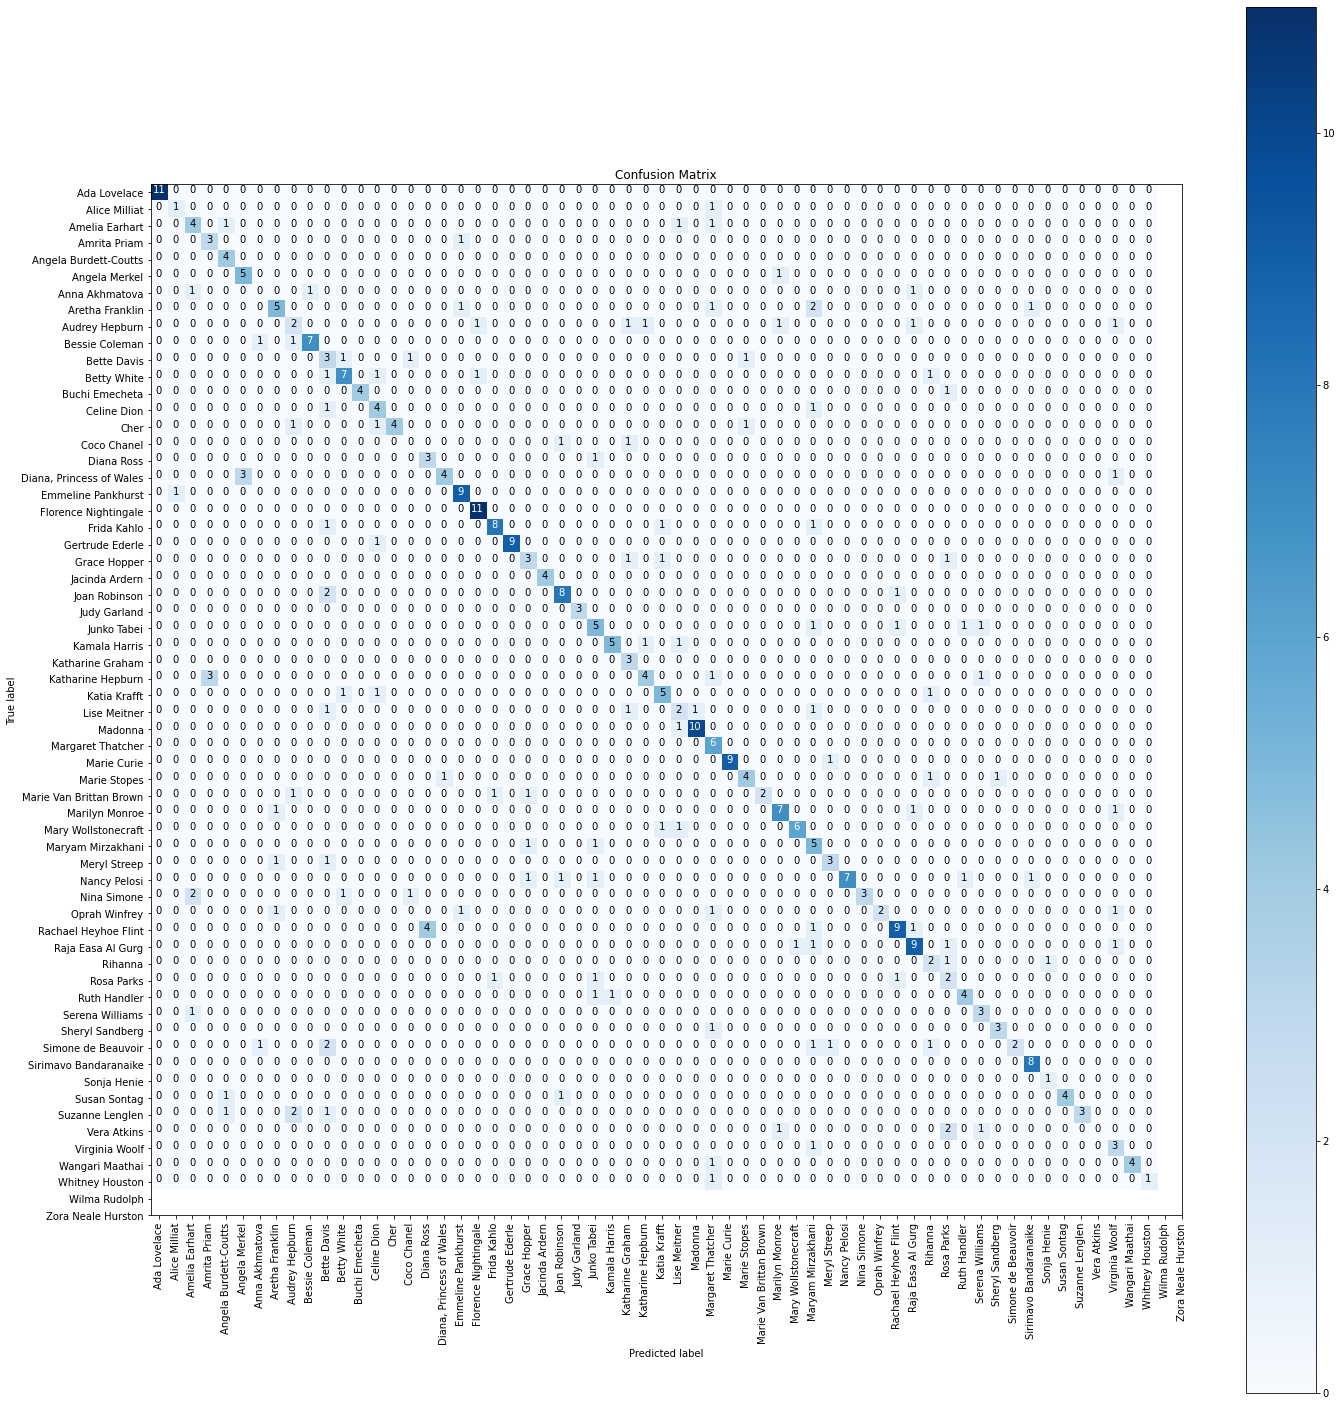

In [33]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

### 3. MobileNet_V2 

In [35]:
x = [] # Feature dataset with images
y = [] # Target dataset with labels


folder_dir = './output/train/_cropped/'
size = (224,224) #Crop the image to 224x224
for folder in os.listdir(folder_dir):
    for file in os.listdir(os.path.join(folder_dir, folder)):
        if file.endswith("png"):
            y.append(folder)
            img = cv2.imread(os.path.join(folder_dir, folder, file))
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            im = cv2.resize(img_rgb, (size))
            x.append(im)
        else:
            continue

In [36]:
# having the model ready
model_cl = tf.keras.Sequential ([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2", input_shape = size +(3,))
]) 

In [37]:
# split the dataset into 80% training and 20% test sets:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20)

In [38]:
y_train = LabelEncoder().fit_transform(y_train)
y_test = LabelEncoder().fit_transform(y_test)

In [39]:
y_train

array([60, 13, 41, ..., 31, 26, 14], dtype=int64)

In [40]:
X_train = np.array(X_train)/255
X_test= np.array(X_test)/255

In [41]:
# the feature vector gives all the layers except the last one 
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

In [42]:
# trainable false means freeze, do not train (all the layers will have their fixed weights)
pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [43]:
num_of_labels = 62

# create the last layer 
model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_labels)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 62)                79422     
Total params: 2,337,406
Trainable params: 79,422
Non-trainable params: 2,257,984
_________________________________________________________________


In [44]:
# Train the model
model.compile(optimizer="adam", loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs= 20, validation_split=0.2, verbose = 1)

Epoch 1/20
33/33 [==============================] - 19s 498ms/step - loss: 3.9402 - accuracy: 0.1144 - val_loss: 3.2615 - val_accuracy: 0.1939
Epoch 2/20
33/33 [==============================] - 15s 466ms/step - loss: 2.5047 - accuracy: 0.4690 - val_loss: 2.5879 - val_accuracy: 0.3916
Epoch 3/20
33/33 [==============================] - 15s 462ms/step - loss: 1.7487 - accuracy: 0.6787 - val_loss: 2.1821 - val_accuracy: 0.5247
Epoch 4/20
33/33 [==============================] - 15s 447ms/step - loss: 1.3034 - accuracy: 0.7865 - val_loss: 1.9492 - val_accuracy: 0.5894
Epoch 5/20
33/33 [==============================] - 15s 445ms/step - loss: 0.9877 - accuracy: 0.8599 - val_loss: 1.7818 - val_accuracy: 0.6008
Epoch 6/20
33/33 [==============================] - 15s 443ms/step - loss: 0.7785 - accuracy: 0.9218 - val_loss: 1.6590 - val_accuracy: 0.6274
Epoch 7/20
33/33 [==============================] - 14s 442ms/step - loss: 0.6348 - accuracy: 0.9418 - val_loss: 1.5916 - val_accuracy: 0.6426

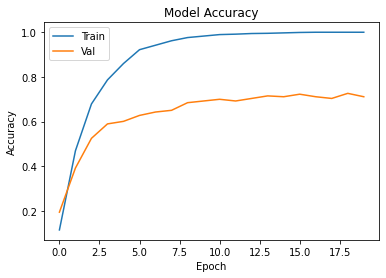

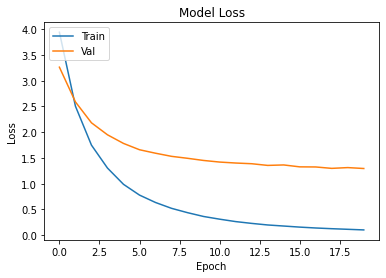

In [45]:
#accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

#Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Train','Val'],loc='upper left')
plt.show()

In [46]:
# Prediction
predict_model = model.predict(np.array(X_train))
predict_model = np.argmax(predict_model, axis=1)
predict_model

array([60, 13, 41, ..., 22, 26, 14], dtype=int64)

In [47]:
cm_mobilenet = confusion_matrix(y_true = y_train, y_pred = predict_model)

Confusion matrix, without normalization
[[24  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 18 ...  0  0  0]
 ...
 [ 0  0  0 ... 18  0  0]
 [ 0  0  0 ...  0 20  0]
 [ 0  0  0 ...  0  0  9]]


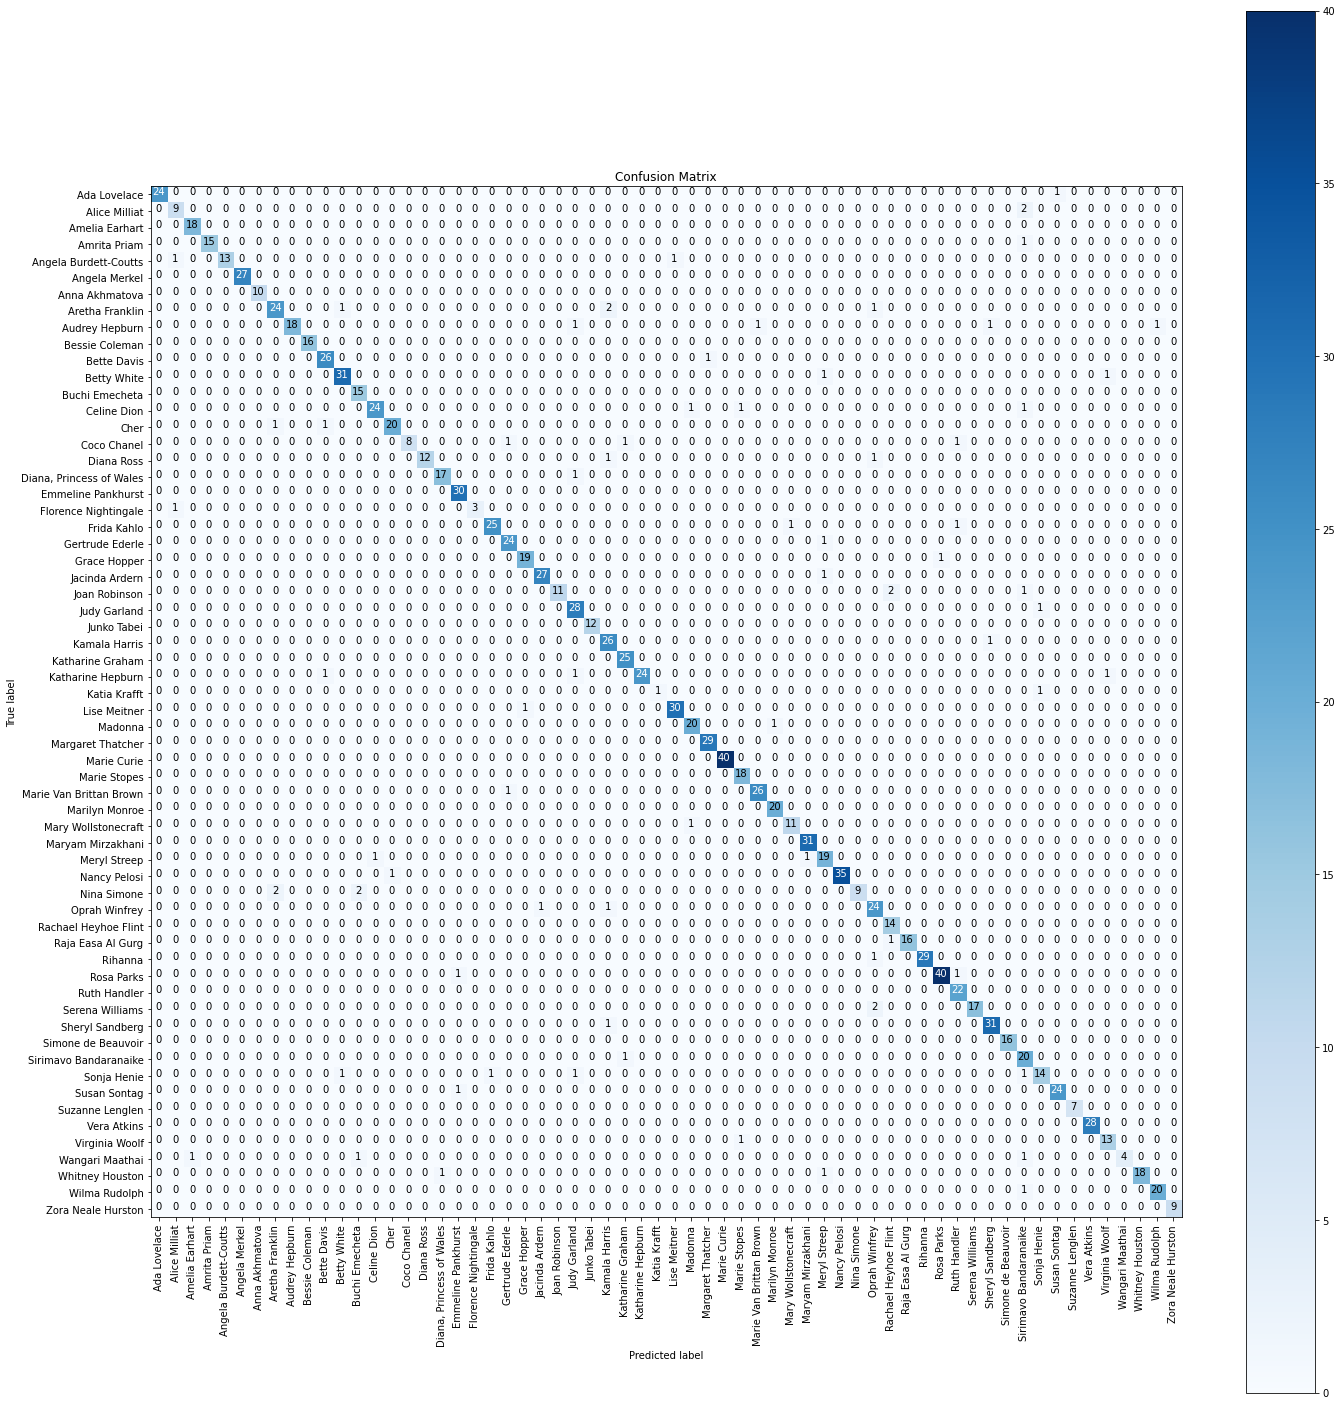

In [48]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_confusion_matrix(cm=cm_mobilenet, classes=cm_plot_labels, title='Confusion Matrix')

In [88]:
#y_test_one_hot = tf.one_hot(y_test, depth=62)

In [89]:
#categories = np.sort(os.listdir(folder_dir))
#size = 224
#fig, ax = plt.subplots(3,3, figsize=(25, 40))

#for i in range(3):
  #  for j in range(3):
    #    k = int(np.random.random_sample() * len(X_test))
      #  if(categories[np.argmax(y_test_one_hot[k])] == categories[np.argmax(model.predict(X_test)[k])]):
        #    ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test_one_hot[k])], color='green')
          #  ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='green')
            #ax[i,j].imshow(np.array(X_test)[k].reshape(size, size, 3), cmap='gray')
       # else:
         #   ax[i,j].set_title("TRUE: " + categories[np.argmax(y_test_one_hot[k])], color='red')
           # ax[i,j].set_xlabel("PREDICTED: " + categories[np.argmax(model.predict(X_test)[k])], color='red')
            #ax[i,j].imshow(np.array(X_test)[k].reshape(size, size, 3), cmap='gray')

### 4. ResNet50

In [64]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

In [65]:
def gen(pre,train,test):
    train_datagen = ImageDataGenerator(
                        preprocessing_function=pre,
                        validation_split=0.2)
    test_datagen = ImageDataGenerator(
                        preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
        )
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    return train_gen, valid_gen, test_gen

In [66]:
def func(name_model):
    pre_model = name_model(
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input

    x = Dense(600, activation='relu')(pre_model.output)
    x = Dense(600, activation='relu')(x)
    outputs = Dense(62, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_accuracy',
                              patience=5,
                              min_delta=0,
                              mode='auto')]
    return model, my_callbacks

In [67]:
def plot(history,test_gen,train_gen,model):
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
        
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    # Classification report
    cm=confusion_matrix(test_df.Label,pred)
    clr = classification_report(test_df.Label, pred)
    print(clr)
    # Display 6 picture of the dataset with their labels
    fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.Filepath.iloc[i+1]))
        ax.set_title(f"True: {test_df.Label.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
        
    return history

In [68]:
def result_test(test,model_use):
    results = model_use.evaluate(test, verbose=0)
    print("Test Loss: {:.5f}".format(results[0]))
    print("Test Accuracy: {:.2f}%".format(results[1] * 100))
    
    return results

In [69]:
data = './output/train/_cropped'

In [70]:
file_pathAll = list(glob.glob(data+'/**/*.png'))
labels = list(map(lambda x :os.path.split(os.path.split(x)[0])[1], file_pathAll))
file_path = pd.Series(file_pathAll, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,Filepath,Label
0,./output/train/_cropped\Serena Williams\Serena...,Serena Williams
1,./output/train/_cropped\Virginia Woolf\Virgini...,Virginia Woolf
2,./output/train/_cropped\Sonja Henie\Sonja Heni...,Sonja Henie
3,./output/train/_cropped\Raja Easa Al Gurg\Raja...,Raja Easa Al Gurg
4,./output/train/_cropped\Nina Simone\Nina Simon...,Nina Simone


In [71]:
train_df, test_df = train_test_split(data, test_size=0.2, random_state=1)

In [72]:
RestNet_pre=preprocess_input
train_gen_RestNet, valid_gen_RestNet, test_gen_RestNet = gen(RestNet_pre,train_df, test_df)

Found 1050 validated image filenames belonging to 62 classes.
Found 262 validated image filenames belonging to 62 classes.
Found 329 validated image filenames belonging to 61 classes.


In [73]:
ResNet50_model, callback=func(ResNet50)
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [74]:
history = ResNet50_model.fit(
    train_gen_RestNet,
    validation_data=valid_gen_RestNet,
    epochs=10,
    callbacks=callback)

Epoch 1/10
33/33 [==============================] - 61s 2s/step - loss: 3.5429 - accuracy: 0.1800 - val_loss: 2.6071 - val_accuracy: 0.3130
Epoch 2/10
33/33 [==============================] - 59s 2s/step - loss: 1.8298 - accuracy: 0.5390 - val_loss: 1.8899 - val_accuracy: 0.5305
Epoch 3/10
33/33 [==============================] - 62s 2s/step - loss: 1.0607 - accuracy: 0.7295 - val_loss: 1.4372 - val_accuracy: 0.6221
Epoch 4/10
33/33 [==============================] - 59s 2s/step - loss: 0.6137 - accuracy: 0.8467 - val_loss: 1.2569 - val_accuracy: 0.6756
Epoch 5/10
33/33 [==============================] - 60s 2s/step - loss: 0.3602 - accuracy: 0.9124 - val_loss: 1.0639 - val_accuracy: 0.7099
Epoch 6/10
33/33 [==============================] - 56s 2s/step - loss: 0.1779 - accuracy: 0.9638 - val_loss: 1.1030 - val_accuracy: 0.7176
Epoch 7/10
33/33 [==============================] - 57s 2s/step - loss: 0.0837 - accuracy: 0.9924 - val_loss: 1.0461 - val_accuracy: 0.7786
Epoch 8/10
33/33 [==

C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                          precision    recall  f1-score   support

            Ada Lovelace       0.75      1.00      0.86         3
           Alice Milliat       0.00      0.00      0.00         3
          Amelia Earhart       0.71      1.00      0.83         5
            Amrita Priam       0.50      0.50      0.50         2
   Angela Burdett-Coutts       1.00      0.50      0.67         4
           Angela Merkel       0.92      1.00      0.96        11
          Anna Akhmatova       0.50      0.25      0.33         4
         Aretha Franklin       0.71      0.71      0.71         7
          Audrey Hepburn       0.60      1.00      0.75         3
          Bessie Coleman       0.33      0.50      0.40         2
             Bette Davis       0.25      0.50      0.33         4
             Betty White       0.75      0.38      0.50         8
          Buchi Emecheta       0.50      1.00      0.67         2
             Celine Dion       0.57      0.80      0.67         5
         

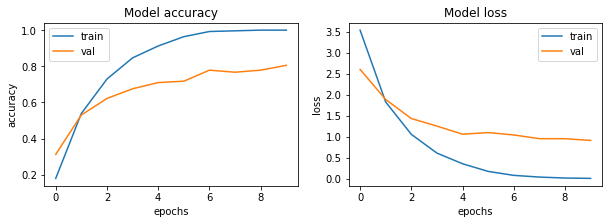

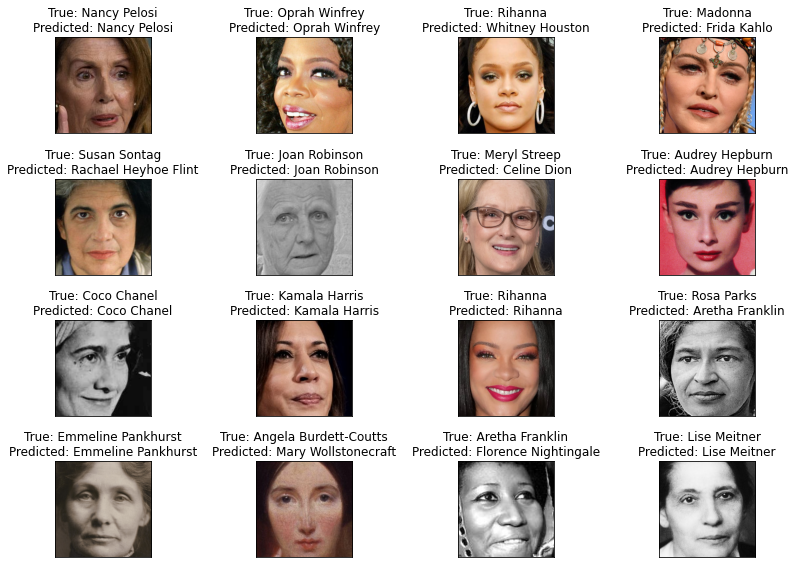

In [75]:
history_ResNet=plot(history,test_gen_RestNet,train_gen_RestNet,ResNet50_model)

In [82]:
#result_ResNet = result_test(test_gen_RestNet,ResNet50_model)

### 5. DenseNet201

In [79]:
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.applications.densenet import preprocess_input
DenseNet201_pre=preprocess_input
train_gen_DenseNet201, valid_gen_DenseNet201, test_gen_DenseNet201 = gen(DenseNet201_pre,train_df, test_df)

Found 1050 validated image filenames belonging to 62 classes.
Found 262 validated image filenames belonging to 62 classes.
Found 329 validated image filenames belonging to 61 classes.


In [80]:
DenseNet201_model, callback=func(DenseNet201)

74850304/74836368 [==============================] - 9s 0us/step


In [81]:
history_DenseNet201 = DenseNet201_model.fit(
    train_gen_DenseNet201,
    validation_data=valid_gen_DenseNet201,
    epochs=10,
    callbacks=callback)

Epoch 1/10
33/33 [==============================] - 111s 3s/step - loss: 3.6807 - accuracy: 0.1381 - val_loss: 2.9386 - val_accuracy: 0.2557
Epoch 2/10
33/33 [==============================] - 98s 3s/step - loss: 2.2000 - accuracy: 0.4638 - val_loss: 2.1007 - val_accuracy: 0.4580
Epoch 3/10
33/33 [==============================] - 100s 3s/step - loss: 1.4371 - accuracy: 0.6362 - val_loss: 1.5211 - val_accuracy: 0.6107
Epoch 4/10
33/33 [==============================] - 102s 3s/step - loss: 0.8533 - accuracy: 0.7819 - val_loss: 1.3660 - val_accuracy: 0.6374
Epoch 5/10
33/33 [==============================] - 104s 3s/step - loss: 0.5725 - accuracy: 0.8676 - val_loss: 1.1955 - val_accuracy: 0.7061
Epoch 6/10
33/33 [==============================] - 104s 3s/step - loss: 0.3790 - accuracy: 0.9152 - val_loss: 1.2983 - val_accuracy: 0.6489
Epoch 7/10
33/33 [==============================] - 106s 3s/step - loss: 0.2472 - accuracy: 0.9562 - val_loss: 1.1446 - val_accuracy: 0.7137
Epoch 8/10
33/

C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Program Files\Anaconda\lib\site-packages\sklearn\metrics\

                          precision    recall  f1-score   support

            Ada Lovelace       1.00      1.00      1.00         3
           Alice Milliat       0.00      0.00      0.00         3
          Amelia Earhart       0.71      1.00      0.83         5
            Amrita Priam       1.00      0.50      0.67         2
   Angela Burdett-Coutts       1.00      0.75      0.86         4
           Angela Merkel       0.85      1.00      0.92        11
          Anna Akhmatova       1.00      0.50      0.67         4
         Aretha Franklin       1.00      0.14      0.25         7
          Audrey Hepburn       0.38      1.00      0.55         3
          Bessie Coleman       0.67      1.00      0.80         2
             Bette Davis       0.11      0.50      0.18         4
             Betty White       0.50      0.38      0.43         8
          Buchi Emecheta       1.00      1.00      1.00         2
             Celine Dion       0.57      0.80      0.67         5
         

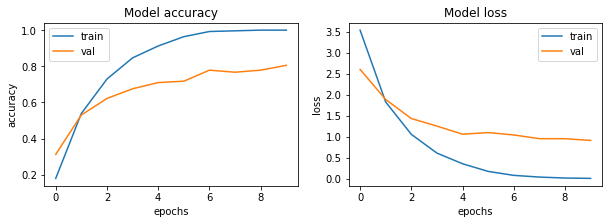

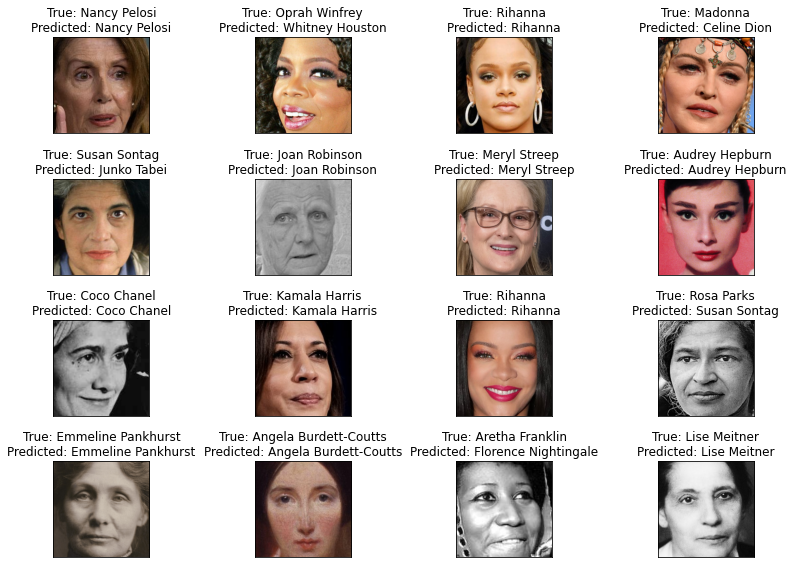

In [83]:
history_DenseNet201=plot(history,test_gen_DenseNet201,train_gen_DenseNet201,DenseNet201_model)

In [85]:
#result_DenseNet201 = result_test(test_gen_DenseNet201,DenseNet201_model)